In [59]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
import random

from experiments.npe.model_variational import get_npe_model, get_coef, get_lossfunc
import experiments.npe.model as original_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
with open('data/threecircles_munk_1.0.p', 'rb') as f:
    data = pickle.load(f)
    
train_x, train_y, complexities = data['train']

c = list(zip(train_x, train_y))
random.shuffle(c)
train_x, train_y = zip(*c)

val_x, val_y = data['val']

c = list(zip(val_x, val_y))
random.shuffle(c)
val_x, val_y = zip(*c)

def breakdown(X):
    return [
        np.array([x[0] for x in X]),
        np.array([x[1] for x in X]),
        np.array([x[2] for x in X]),
        np.array([x[3] for x in X]),
        np.array([x[4] for x in X]),
    ]

In [117]:
tf.keras.backend.set_floatx('float64')

model = get_npe_model(max_pairs = 2, hidden_size=512)
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0003, clipnorm=1.0)

# def nll(y, model):
#     return tf.clip_by_value(-model.log_prob(y), -1000, 100) #tf.keras.losses.MSE(model.mean(), y)

def nll(y, model):
    return -model.log_prob(y) #tf.keras.losses.MSE(model.mean(), y)

def mse(y, model):
    return tf.keras.losses.MSE(model.mean(), y)

def giga_loss(true, predicted):
    o_mux, o_muy, o_sx, o_sy, o_corr = get_coef(predicted)
    return get_lossfunc(o_mux, o_muy, o_sx, o_sy, o_corr, true[...,0], true[...,1])

model.compile(loss=nll, optimizer=opt, metrics=['mse'])
# model.compile(loss='mse', optimizer=opt)
# model.compile(loss=giga_loss, optimizer=opt)

In [118]:
tf.keras.backend.set_floatx('float64')

b_train_x = breakdown(train_x)
b_val_x = breakdown(val_x)

base_loss = []
base_nums = []

for epoch in range(100):
    h = model.fit(b_train_x, np.array(train_y), validation_data=(b_val_x, np.array(val_y)), epochs=1, batch_size=50)
    
#     base_loss.append(h.history['val_mse'][-1])
    
    if len(base_nums) == 0:
        base_nums.append(len(train_x))
    else:
        base_nums.append(len(train_x) + base_nums[-1])
        
#     show_simulation(model, length=50)

Train on 100000 samples, validate on 10000 samples
100000/100000 [==============================] - 21s 214us/sample - loss: -0.0459 - mse: 0.0661 - val_loss: -1.5247 - val_mse: 0.0253
Train on 100000 samples, validate on 10000 samples
100000/100000 [==============================] - 20s 198us/sample - loss: -1.1936 - mse: 0.0282 - val_loss: -2.1653 - val_mse: 0.0142
Train on 100000 samples, validate on 10000 samples
100000/100000 [==============================] - 21s 207us/sample - loss: -1.5771 - mse: 0.0197 - val_loss: -0.4882 - val_mse: 0.0296
Train on 100000 samples, validate on 10000 samples
100000/100000 [==============================] - 20s 204us/sample - loss: 59.4432 - mse: 0.0173 - val_loss: -2.5251 - val_mse: 0.0115
Train on 100000 samples, validate on 10000 samples
100000/100000 [==============================] - 20s 200us/sample - loss: 100.7852 - mse: 0.0153 - val_loss: -0.3484 - val_mse: 0.0239
Train on 100000 samples, validate on 10000 samples
100000/100000 [========

KeyboardInterrupt: 

In [114]:
tf.keras.backend.set_floatx('float64')

exp_loss = []
exp_nums = []

b_train_x = breakdown(train_x)
b_val_x = breakdown(val_x)

current_train = np.arange(len(train_x))

for epoch in range(100):
    h = model.fit(
        breakdown(np.array(train_x)[current_train]),
        np.array(train_y)[current_train],
        validation_data=(b_val_x, np.array(val_y)),
        epochs=1,
        batch_size=50)
    
    exp_loss.append(h.history['val_mse'][-1])
    
    if len(exp_nums) == 0:
        exp_nums.append(len(current_train))
    else:
        exp_nums.append(len(current_train) + exp_nums[-1])
    
    dist = model(breakdown(train_x))
    variances = (np.sum(np.abs(dist.stddev().numpy())**2,axis=-1)**(1./2))
    
    current_train = np.squeeze(np.argwhere(variances > 0.15))

Train on 100000 samples, validate on 10000 samples
100000/100000 [==============================] - 22s 216us/sample - loss: -0.0402 - mse: 0.0669 - val_loss: 1.9723 - val_mse: 0.1038
Train on 95680 samples, validate on 10000 samples
95680/95680 [==============================] - 23s 237us/sample - loss: -1.1001 - mse: 0.0298 - val_loss: -0.7535 - val_mse: 0.0310
Train on 48537 samples, validate on 10000 samples
48537/48537 [==============================] - 11s 236us/sample - loss: -0.7680 - mse: 0.0331 - val_loss: -1.7450 - val_mse: 0.0154
Train on 22689 samples, validate on 10000 samples
22689/22689 [==============================] - 6s 262us/sample - loss: 33.1489 - mse: 0.0481 - val_loss: 0.6807 - val_mse: 0.0446
Train on 47379 samples, validate on 10000 samples
47379/47379 [==============================] - 11s 236us/sample - loss: -1.0267 - mse: 0.0299 - val_loss: -0.4639 - val_mse: 0.0172
Train on 19692 samples, validate on 10000 samples
19692/19692 [===========================

KeyboardInterrupt: 

In [15]:
current_train

array([[    0],
       [    1],
       [    2],
       ...,
       [99997],
       [99998],
       [99999]])

In [116]:
from experiments.npe.simulate import show_simulation, show_simulation_variational
# show_simulation_variational(model, length=5)
show_simulation(model)

KeyboardInterrupt: 

In [143]:
from tensorflow.keras.models import Model

model.layers[-1].inputs

[<tf.Tensor 'input_38:0' shape=(None, 4) dtype=float64>,
 <tf.Tensor 'input_39:0' shape=(None, 64) dtype=float64>]

In [87]:
dist = model(breakdown(train_x))

In [88]:
dist.log_prob(np.array(train_y)).numpy().max()

5.444577408624591

In [16]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 4)]          0                                            
____________________________________________________________________________________________

In [128]:
dist = model(breakdown(val_x))

In [129]:
indexes = (np.sum(np.abs(dist.stddev().numpy())**2,axis=-1)**(1./2)).argsort()[::-1]

/home/shreyask/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


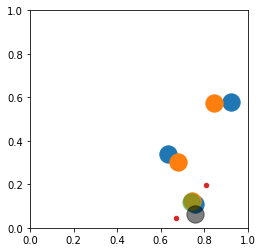

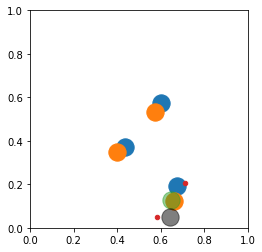

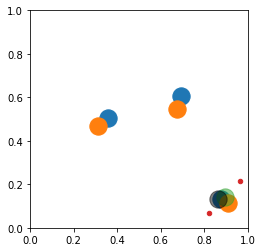

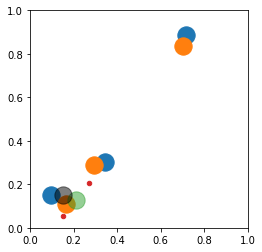

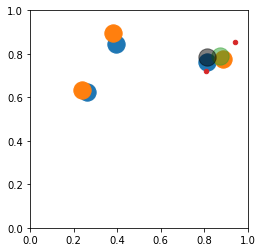

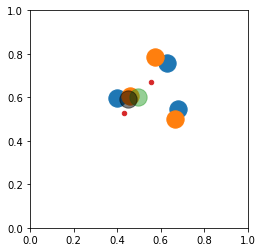

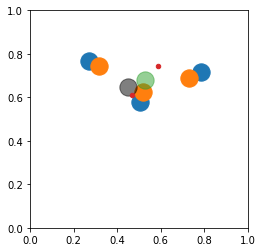

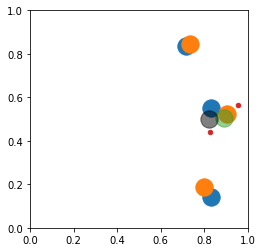

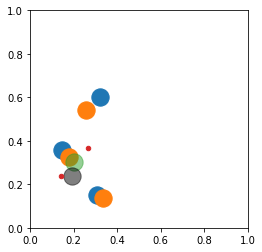

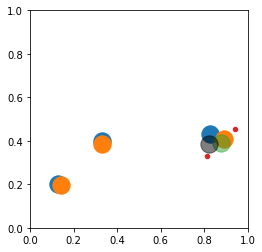

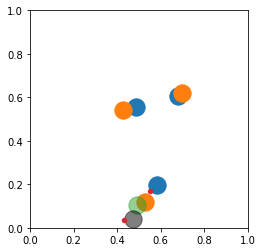

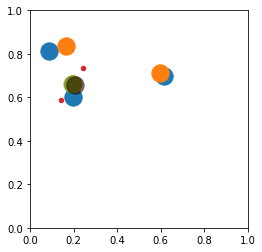

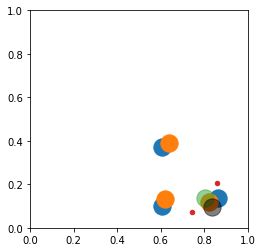

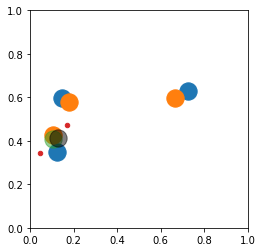

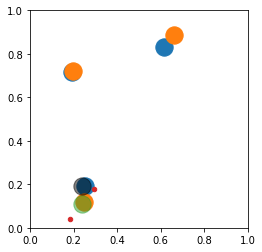

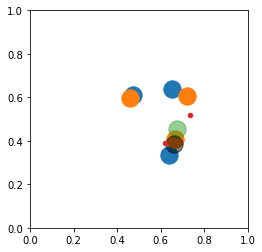

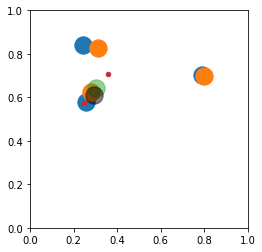

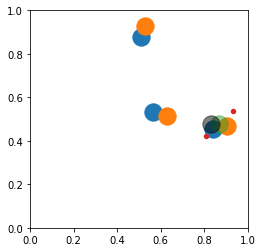

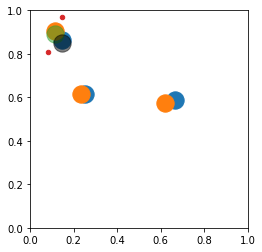

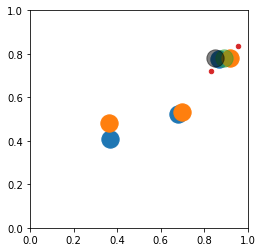

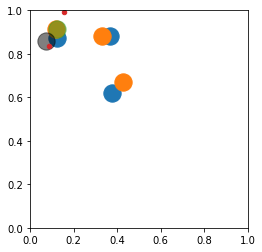

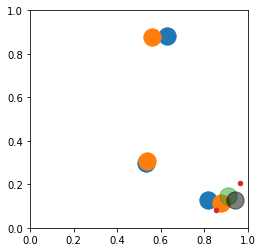

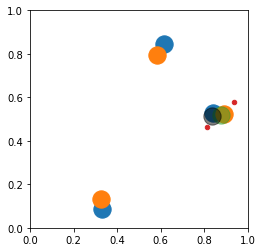

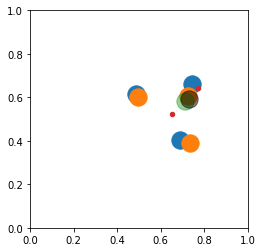

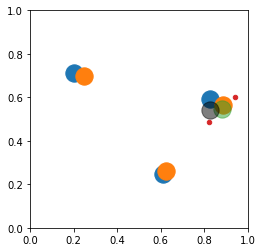

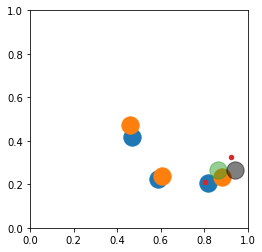

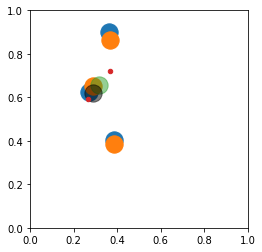

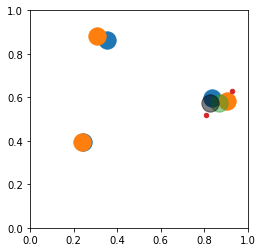

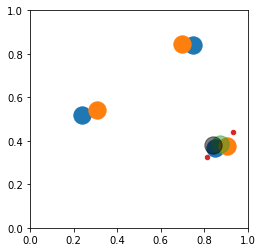

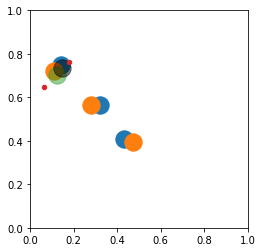

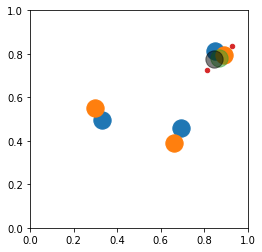

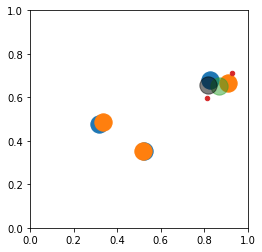

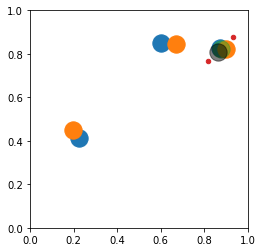

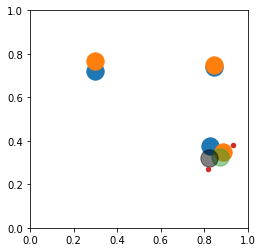

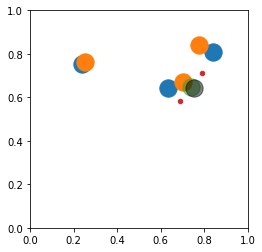

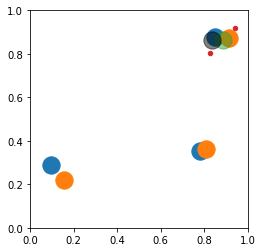

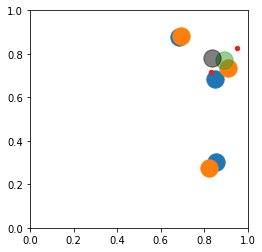

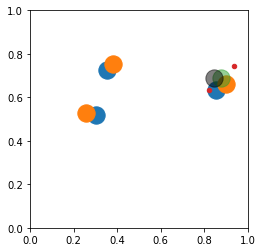

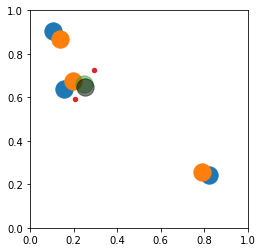

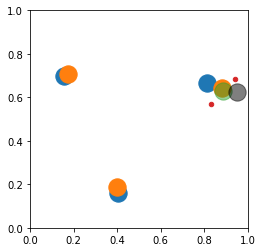

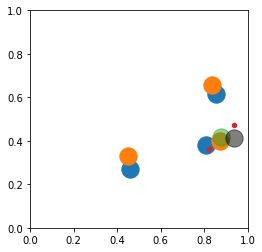

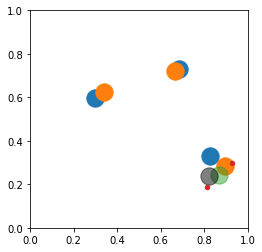

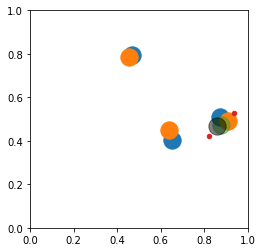

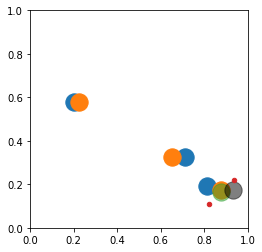

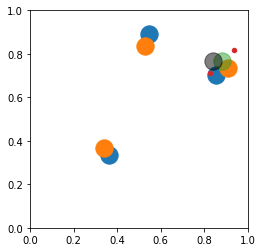

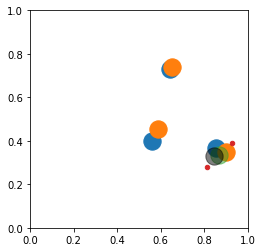

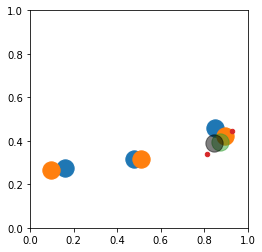

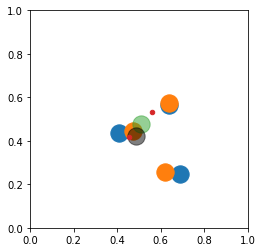

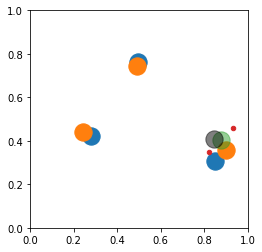

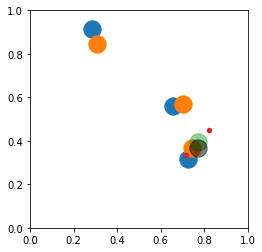

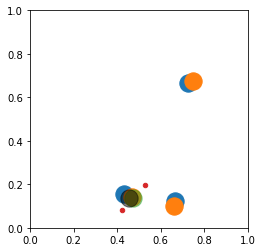

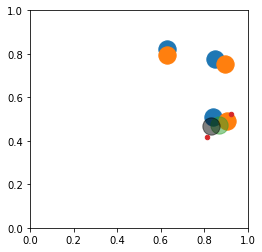

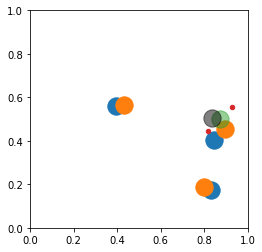

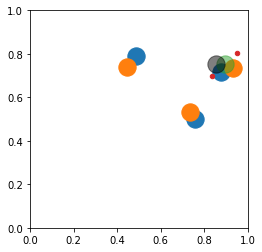

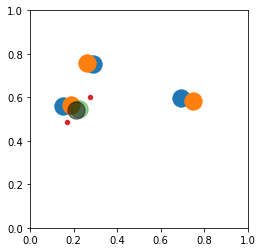

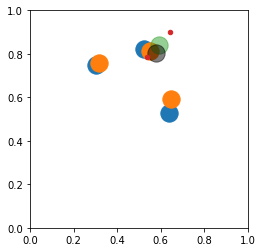

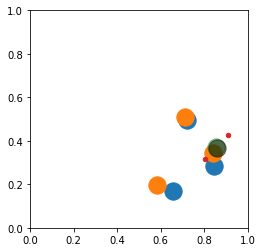

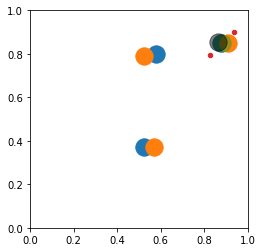

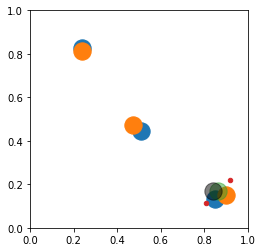

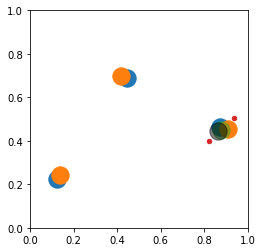

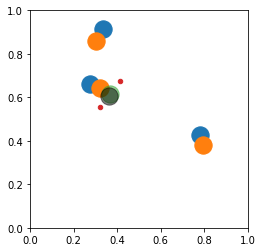

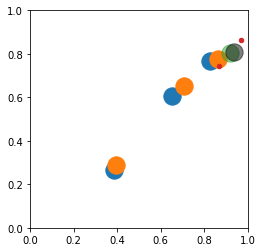

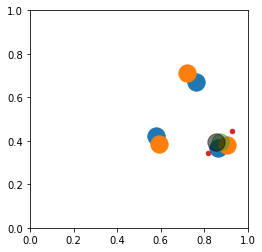

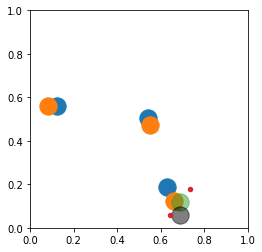

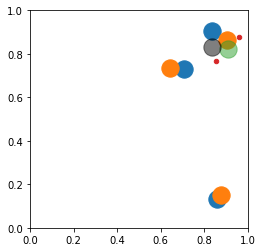

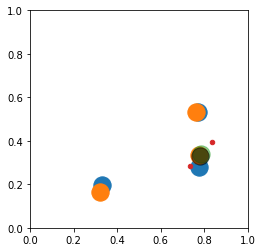

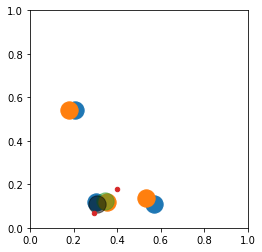

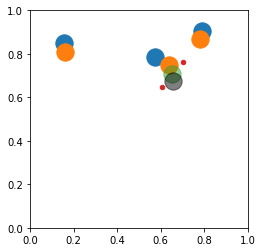

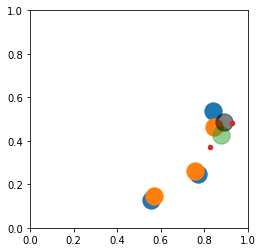

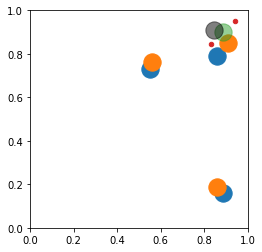

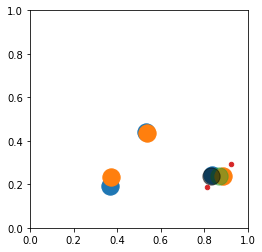

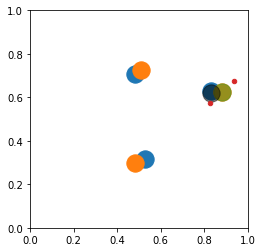

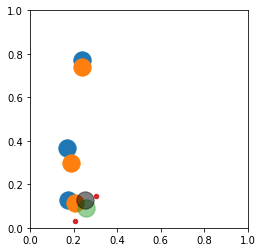

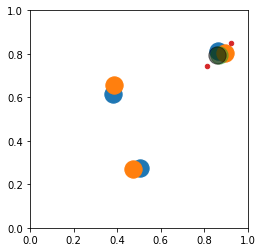

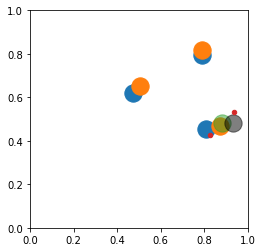

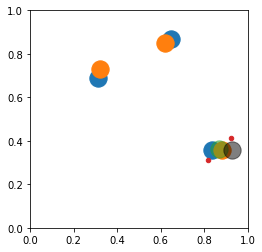

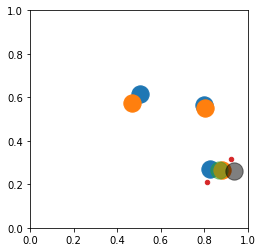

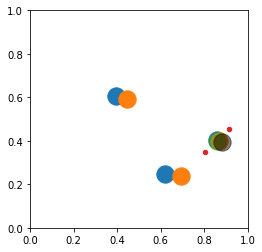

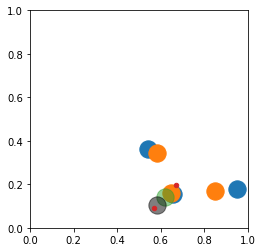

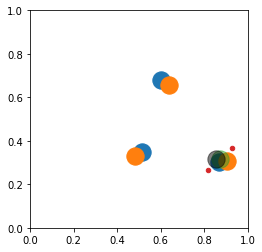

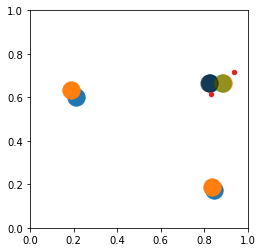

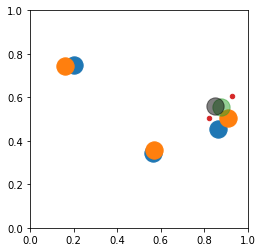

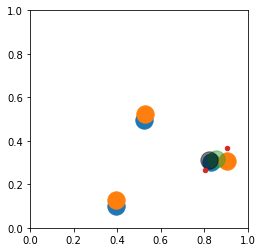

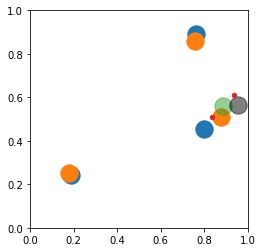

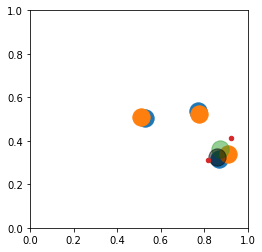

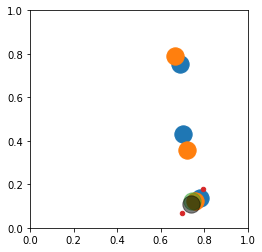

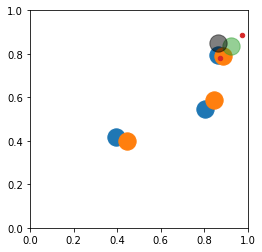

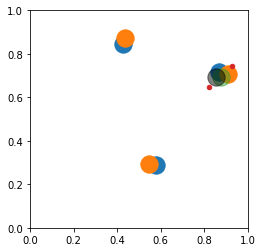

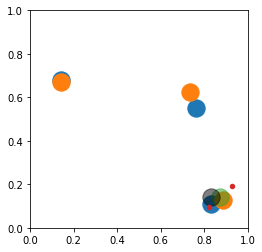

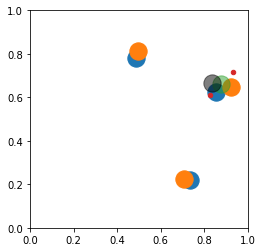

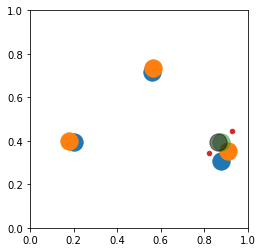

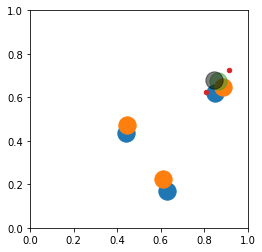

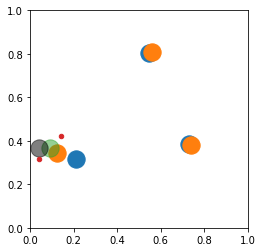

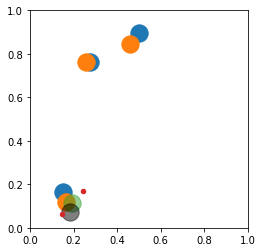

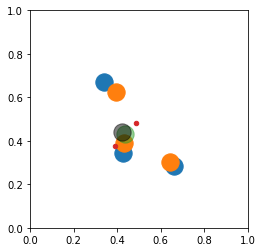

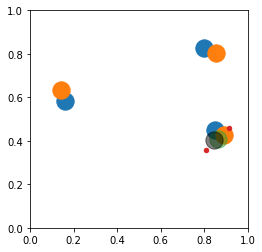

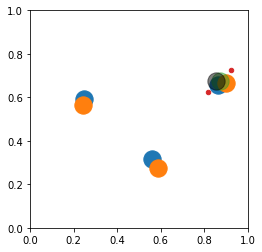

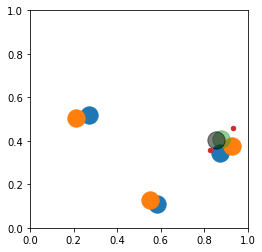

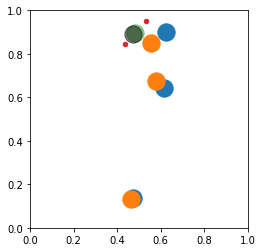

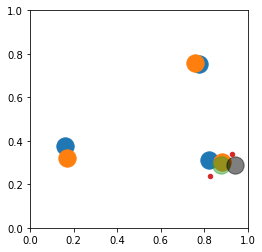

In [131]:
i = 136

s = 300

for i in indexes[:100]:
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.axes().set_aspect('equal')
    
    m = np.array(val_x[i][:3])
    plt.scatter(m[:, 0], m[:, 1], s = s)
    plt.scatter(m[:, 2], m[:, 3], s = s)

    v = dist.mean()[i].numpy()
    vv = dist.stddev()[i].numpy()

    f = m[0][2:] + v / 10.0
    fu = m[0][2:] + (v + 2 * vv) / 10.0
    fl = m[0][2:] + (v - 2 * vv) / 10.0
    
    a = m[0][2:] + (val_y[i]) / 10.0


    plt.scatter([f[0]], [f[1]], s = s, alpha = 0.5)
    plt.scatter([a[0]], [a[1]], s = s, c='black', alpha = 0.5)

    plt.scatter([fu[0], fl[0]], [fu[1], fl[1]], s = 20)
    plt.show()

In [25]:
model.save('variation_error_detect.h5')

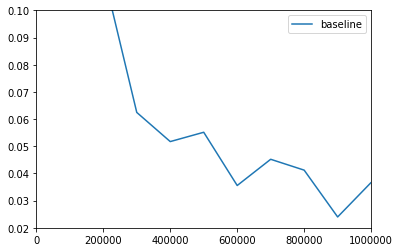

In [31]:
cutoff = 0
# plt.plot(exp_nums, exp_loss, label="exp")
plt.plot(base_nums, base_loss, label="baseline")
plt.ylim((0.02, 0.1))
plt.xlim((0.0, 10e5))
plt.legend()

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    return ax

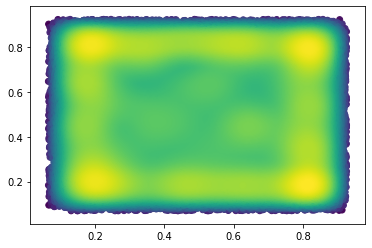

In [58]:
px = []
py = []

for t in range(len(train_x)):
    points_p = np.array([train_x[t][i][:2] for i in range(3)])
    points_n = np.array([train_x[t][i][2:] for i in range(3)])

#     plt.scatter(points_p[:, 0], points_p[:, 1])
#     plt.scatter(points_n[:, 0], points_n[:, 1])
#     plt.scatter([train_x[t][0][2:][0] + train_y[t][0]], [train_x[t][0][2:][1] + train_y[t][1]])

    # Position
    px.append(train_x[t][0][2:][0] + train_y[t][0] * 1/10.0)
    py.append(train_x[t][0][2:][1] + train_y[t][1] * 1/10.0)
    
    # Velocity
#     px.append(points_n[0][0] - points_p[0][0])
#     py.append(points_n[0][1] - points_p[0][1])
    
#     px.append(points_p[0][0])
#     py.append(points_p[0][1])
    
density_scatter(np.array(px), np.array(py), bins=10)

In [134]:
np.abs(np.array(train_y)[:, 0]).max(), np.array(train_y)[:, 1].max()

(1.5873422493824574, 1.3543038143525685)

In [136]:
np.max(np.array(train_y) / 1.5873422493824574)

0.9347805139055114